# Подготовка данных
## Анализ данных

In [1]:
# импортируем библиотеки:
import warnings
warnings.filterwarnings('ignore')

import mlflow
import optuna
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:9000")
client=mlflow.MlflowClient(tracking_uri='http://127.0.0.1:9000')
sklearn.set_config(transform_output='pandas')

In [2]:
# загрузим файл и изучим общую информацию о нем:
df = pd.read_csv('Autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# найдем пропуски в данных:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# найдем явные дубликаты:
df.duplicated().sum()

4

In [6]:
# удалим явные дубликаты:
df = df.drop_duplicates()

Определим признаки, важные для модели.

К значимым признакам отнесем следующие столбцы:

- VehicleType. Тип машины определяет ее функционал. Чем больше возможностей у машины, тем выше цена.
- Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
- Power. Мощность в лошадиных силах (далее л.с.) напрямую влияют на цену.
- Kilometer. Имеет обратно пропорциональную зависимость от цены. Чем больше километров проехала машина, тем меньше ее надежность и, соответственно, цена.
- FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
- Brand. Концерн/компания, которая создала автомобиль, показывает качество и надежность автомобиля.
- Repaired. Машины, которые побывали в дорожно-транспортных происшествиях, подверглись изменениям, и их надежность ниже.
- RegistrationYear. Год регистрации определяет, сколько уже лет машина на ходу, соответственно, чем больше возраст, тем меньше цена.
- Model. Тоже может влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость и не являются информативными: 
- DateCrawled (дата скачивания анкеты из базы), 
- RegistrationMonth(месяц регистрации автомобиля), 
- DateCreated (дата создания анкеты), 
- NumberOfPictures (количество фотографий автомобиля), 
- PostalCode (почтовый индекс владельца анкеты (пользователя)),
- LastSeen (дата последней активности пользователя).

## Предобработка данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

In [8]:
# проверим значения:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,13718,NaN,NaN,17
mean,NaN,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,NaN,0.0,50508.503800,NaN
std,NaN,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,3.726432,NaN,NaN,NaN,NaN,0.0,25783.100078,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Столбцы, требующие обработки:

- VehicleType. Для всех NaN установим значение 'unknown'.
- Gearbox. Для всех NaN установим значение 'unknown'.
- Power. Скорректируем на основе реальных значений в машинах. Иметь 20000 л.с. для машины на данный момент нереально.
- FuelType. Восстановим пропущенные значения по популярному типу. ????????????
- Repaired. Для всех NaN установим значение 'no'. ?????????
- RegistrationYear. Скорректируем на основе реальных значений в машинах.
- Model. Для всех NaN установим значение 'unknown'.

### Обработка выбросов
#### Признак RegistrationYear

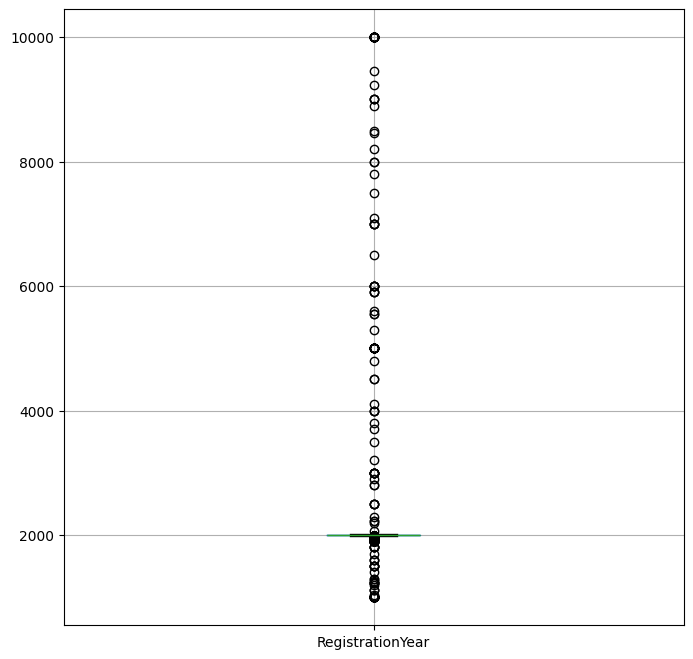

In [9]:
df.boxplot(column=['RegistrationYear'], figsize=(8,8))
plt.show()

In [10]:
# найдем уникальные значения в столбце RegistrationYear и выполним сортировку по индексу:
df['RegistrationYear'].value_counts().sort_index()

RegistrationYear
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: count, Length: 151, dtype: int64

In [11]:
# проверим даты скачивания анкет из базы:
print(df['DateCrawled'].min())
print(df['DateCrawled'].max())

2016-03-05 14:06:22
2016-04-07 14:36:58


Поскольку наши данные на 2016 год, заменим все значения с годом после 2016 на 2016, и, поскольку автомобили до 1930 года - это скорее всего аномалии, заменим их тоже.

In [12]:
# обработаем выбросы в столбце RegistrationYear: 
def balance_reg_year(value):
    if value > 2016:
        return 2016
    elif value < 1930:
        return 1930
    else:
        return value

df["RegistrationYear"] = df["RegistrationYear"].apply(balance_reg_year)

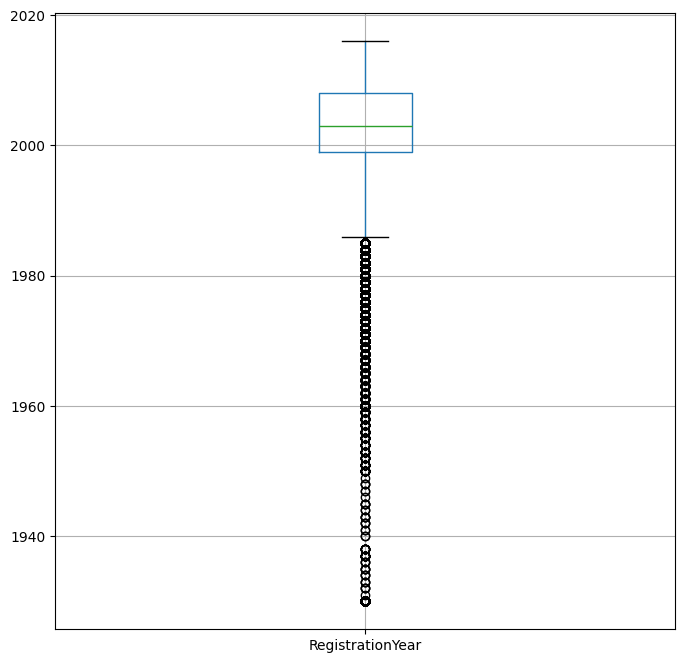

In [13]:
df.boxplot(column=['RegistrationYear'], figsize=(8,8))
plt.show()

#### Признак Power

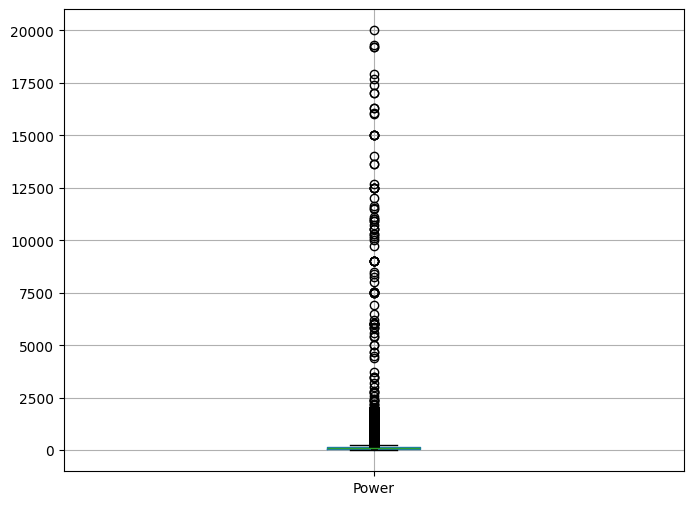

In [14]:
df.boxplot(column=['Power'], figsize=(8,6))
plt.show()

In [15]:
# найдем уникальные значения в столбце Power и выполним сортировку по индексу:
df['Power'].value_counts().sort_index()

Power
0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: count, Length: 712, dtype: int64

In [16]:
# ограничим признак Power 3500 л.с.:
df["Power"] = df["Power"].apply(lambda x: 3500 if x > 3500 else x)

Поскольку иметь 0 л.с. для машины на данный момент нереально, изучим эти данные.

In [17]:
# посчитаем, какой процент от всего датасета занимают строки, где мощность двигателя указана как 0:
print('{:.2f}'.format(df[df['Power'] == 0].shape[0]/df.shape[0]*100))

11.35


In [18]:
# посмотрим на марки автомобилей, мощность которых указана как 0:
df[df['Power'] == 0]['Model'].value_counts()

Model
other         3169
golf          2460
corsa         1771
polo          1611
3er           1534
              ... 
serie_3          1
b_max            1
amarok           1
yeti             1
elefantino       1
Name: count, Length: 247, dtype: int64

In [19]:
# заменим нули на самое частое значение для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        if df[df['Model'] == model]['Power'].value_counts().index[0] == 0:
            new_value = df[df['Model'] == model]['Power'].value_counts().index[1]
            df.loc[(df['Power'] == 0) & (df['Model'] == model), 'Power'] = new_value
        else:
            new_value = df[df['Model'] == model]['Power'].value_counts().index[0]
            df.loc[(df['Power'] == 0) & (df['Model'] == model), 'Power'] = new_value
    except:
        IndexError

In [20]:
# проверим, остались ли нулевые значения и в каком количестве:
print('{:.2f}'.format(df[df['Power'] == 0].shape[0]/df.shape[0]*100))

1.78


In [21]:
# посмотрим на эти данные:
df[df['Power'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
260,2016-04-04 09:49:59,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no,2016-04-04 00:00:00,0,59302,2016-04-06 11:17:11
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
308,2016-03-13 13:38:54,1600,wagon,1999,manual,0,NaN,150000,6,petrol,bmw,no,2016-03-13 00:00:00,0,41199,2016-03-28 12:46:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354080,2016-04-03 20:37:39,4300,small,2008,auto,0,NaN,150000,3,NaN,honda,NaN,2016-04-03 00:00:00,0,30627,2016-04-05 21:16:51
354083,2016-03-30 07:54:17,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-30 00:00:00,0,6686,2016-04-06 23:46:19
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


In [22]:
df.loc[(df['Power'] == 0) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
260,2016-04-04 09:49:59,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no,2016-04-04 00:00:00,0,59302,2016-04-06 11:17:11
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
308,2016-03-13 13:38:54,1600,wagon,1999,manual,0,NaN,150000,6,petrol,bmw,no,2016-03-13 00:00:00,0,41199,2016-03-28 12:46:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354080,2016-04-03 20:37:39,4300,small,2008,auto,0,NaN,150000,3,NaN,honda,NaN,2016-04-03 00:00:00,0,30627,2016-04-05 21:16:51
354083,2016-03-30 07:54:17,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-30 00:00:00,0,6686,2016-04-06 23:46:19
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


Остается 6296 строк (меньше 2% датасета), в которых значения признака Power равны нулю, и во всех этих строках неизвестны модели автомобилей (пропуски). Ограничим мощность двигателей значениями от 10 л.с.:

In [23]:
df = df[df['Power'] > 10]

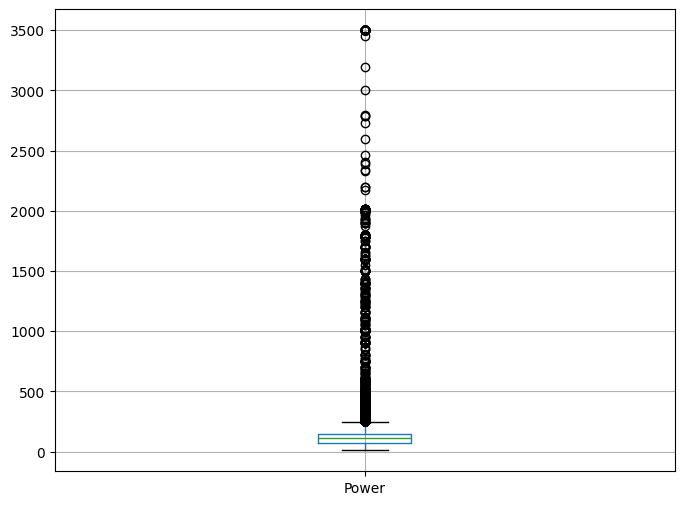

In [24]:
df.boxplot(column=['Power'], figsize=(8,6))
plt.show()

### Обработка пропущенных значений

In [25]:
# процентный список пропущенных данных:
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

DateCrawled - 0.0%
Price - 0.0%
VehicleType - 9.71%
RegistrationYear - 0.0%
Gearbox - 4.78%
Power - 0.0%
Model - 3.81%
Kilometer - 0.0%
RegistrationMonth - 0.0%
FuelType - 8.46%
Brand - 0.0%
Repaired - 19.2%
DateCreated - 0.0%
NumberOfPictures - 0.0%
PostalCode - 0.0%
LastSeen - 0.0%


#### Признак VehicleType

In [26]:
# посмотрим на марки автомобилей с пропусками в признаке VehicleType:
df[df['VehicleType'].isna()]['Model'].value_counts()

Model
golf          4033
other         1856
polo          1600
corsa         1574
3er           1312
              ... 
b_max            1
v60              1
200              1
rangerover       1
q3               1
Name: count, Length: 240, dtype: int64

In [27]:
# заполним пропуски самым частым значением для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        veh_type_imp = df[df['Model'] == model]['VehicleType'].value_counts().index[0]
        df.loc[(df['VehicleType'].isna()) & (df['Model'] == model), 'VehicleType'] = veh_type_imp
    except:
        IndexError

In [28]:
# проверим, остались ли пропуски и в каком количестве:
print('{:.2f}'.format(df[df['VehicleType'].isna()].shape[0]/df.shape[0]*100))

0.90


In [29]:
# посмотрим на эти данные:
df[df['VehicleType'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
435,2016-03-27 18:43:25,1300,NaN,2016,manual,150,NaN,150000,10,NaN,volkswagen,no,2016-03-27 00:00:00,0,70374,2016-04-05 15:15:29
524,2016-03-25 22:53:44,0,NaN,2005,manual,136,NaN,100000,10,NaN,toyota,NaN,2016-03-25 00:00:00,0,86163,2016-03-26 07:44:30
762,2016-03-25 15:56:33,1200,NaN,2016,manual,115,NaN,20000,0,petrol,nissan,no,2016-03-25 00:00:00,0,41334,2016-03-25 15:56:33
862,2016-04-02 13:50:51,380,NaN,2016,manual,54,NaN,100000,0,petrol,skoda,yes,2016-04-02 00:00:00,0,3046,2016-04-02 13:50:51
869,2016-03-22 16:57:42,300,NaN,2016,manual,140,NaN,150000,0,petrol,bmw,NaN,2016-03-22 00:00:00,0,57489,2016-03-26 18:18:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353706,2016-03-24 16:54:28,900,NaN,2016,manual,101,NaN,150000,6,NaN,opel,NaN,2016-03-24 00:00:00,0,50170,2016-04-07 09:17:32
353769,2016-03-25 17:46:19,650,NaN,2000,manual,150,NaN,150000,7,NaN,audi,no,2016-03-25 00:00:00,0,97486,2016-03-27 05:16:34
354007,2016-04-04 21:40:20,10980,NaN,2016,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354011,2016-04-01 02:36:41,1000,NaN,2016,manual,54,NaN,125000,2,NaN,hyundai,no,2016-04-01 00:00:00,0,67547,2016-04-05 02:45:18


In [30]:
df.loc[(df['VehicleType'].isna()) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
435,2016-03-27 18:43:25,1300,NaN,2016,manual,150,NaN,150000,10,NaN,volkswagen,no,2016-03-27 00:00:00,0,70374,2016-04-05 15:15:29
524,2016-03-25 22:53:44,0,NaN,2005,manual,136,NaN,100000,10,NaN,toyota,NaN,2016-03-25 00:00:00,0,86163,2016-03-26 07:44:30
762,2016-03-25 15:56:33,1200,NaN,2016,manual,115,NaN,20000,0,petrol,nissan,no,2016-03-25 00:00:00,0,41334,2016-03-25 15:56:33
862,2016-04-02 13:50:51,380,NaN,2016,manual,54,NaN,100000,0,petrol,skoda,yes,2016-04-02 00:00:00,0,3046,2016-04-02 13:50:51
869,2016-03-22 16:57:42,300,NaN,2016,manual,140,NaN,150000,0,petrol,bmw,NaN,2016-03-22 00:00:00,0,57489,2016-03-26 18:18:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353706,2016-03-24 16:54:28,900,NaN,2016,manual,101,NaN,150000,6,NaN,opel,NaN,2016-03-24 00:00:00,0,50170,2016-04-07 09:17:32
353769,2016-03-25 17:46:19,650,NaN,2000,manual,150,NaN,150000,7,NaN,audi,no,2016-03-25 00:00:00,0,97486,2016-03-27 05:16:34
354007,2016-04-04 21:40:20,10980,NaN,2016,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354011,2016-04-01 02:36:41,1000,NaN,2016,manual,54,NaN,125000,2,NaN,hyundai,no,2016-04-01 00:00:00,0,67547,2016-04-05 02:45:18


Остается 6828 строк (меньше 2% датасета), в которых остались пропуски в признаке VehicleType, и во всех этих строках неизвестны модели автомобилей (пропуски).

#### Признак Gearbox

In [31]:
# посмотрим на марки автомобилей с пропусками в признаке Gearbox:
df[df['Gearbox'].isna()]['Model'].value_counts()

Model
golf                 1475
other                1394
fortwo                786
corsa                 779
polo                  731
                     ... 
range_rover_sport       1
glk                     1
yeti                    1
crossfire               1
nubira                  1
Name: count, Length: 235, dtype: int64

In [32]:
# заполним пропуски самым частым значением для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        veh_type_imp = df[df['Model'] == model]['Gearbox'].value_counts().index[0]
        df.loc[(df['Gearbox'].isna()) & (df['Model'] == model), 'Gearbox'] = veh_type_imp
    except:
        IndexError

In [33]:
# проверим, остались ли пропуски и в каком количестве:
print('{:.2f}'.format(df[df['Gearbox'].isna()].shape[0]/df.shape[0]*100))

0.27


In [34]:
df.loc[(df['Gearbox'].isna()) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
161,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28 00:00:00,0,99086,2016-04-04 11:45:46
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12 00:00:00,0,95131,2016-04-07 14:56:12
1331,2016-04-03 19:53:44,650,NaN,1970,NaN,26,NaN,100000,5,NaN,trabant,NaN,2016-04-03 00:00:00,0,9337,2016-04-05 20:45:24
1345,2016-03-21 01:57:37,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,85057,2016-03-27 21:44:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351669,2016-03-15 15:48:26,2499,sedan,2001,NaN,180,NaN,150000,0,NaN,audi,NaN,2016-03-15 00:00:00,0,53639,2016-03-21 13:16:02
352626,2016-03-28 11:06:23,1850,NaN,2000,NaN,89,NaN,150000,7,NaN,fiat,NaN,2016-03-28 00:00:00,0,56182,2016-03-28 11:06:23
353072,2016-03-27 12:57:36,0,NaN,1990,NaN,75,NaN,150000,0,gasoline,mercedes_benz,NaN,2016-03-27 00:00:00,0,88339,2016-03-27 13:41:54
353104,2016-03-05 23:54:33,1200,NaN,2000,NaN,75,NaN,150000,0,NaN,volkswagen,NaN,2016-03-05 00:00:00,0,86561,2016-03-08 20:48:55


Остается 4131 строка (чуть больше 1% датасета), в которых остались пропуски в признаке Gearbox, и во всех этих строках неизвестны модели автомобилей (пропуски).

#### Признак FuelType

In [35]:
# посмотрим на марки автомобилей с пропусками в признаке FuelType:
df[df['FuelType'].isna()]['Model'].value_counts()

Model
golf                 2429
other                1953
3er                  1330
polo                 1325
corsa                1315
                     ... 
range_rover_sport       1
citigo                  1
v60                     1
musa                    1
discovery               1
Name: count, Length: 235, dtype: int64

In [36]:
# заполним пропуски самым частым значением для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        veh_type_imp = df[df['Model'] == model]['FuelType'].value_counts().index[0]
        df.loc[(df['FuelType'].isna()) & (df['Model'] == model), 'FuelType'] = veh_type_imp
    except:
        IndexError

In [37]:
# проверим, остались ли пропуски и в каком количестве:
print('{:.2f}'.format(df[df['FuelType'].isna()].shape[0]/df.shape[0]*100))

1.07


In [38]:
df.loc[(df['FuelType'].isna()) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12 00:00:00,0,95131,2016-04-07 14:56:12
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29 00:00:00,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353769,2016-03-25 17:46:19,650,NaN,2000,manual,150,NaN,150000,7,NaN,audi,no,2016-03-25 00:00:00,0,97486,2016-03-27 05:16:34
353816,2016-03-09 13:37:36,9800,small,2013,manual,90,NaN,50000,4,NaN,renault,NaN,2016-03-09 00:00:00,0,38855,2016-03-14 20:45:05
354007,2016-04-04 21:40:20,10980,NaN,2016,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354011,2016-04-01 02:36:41,1000,NaN,2016,manual,54,NaN,125000,2,NaN,hyundai,no,2016-04-01 00:00:00,0,67547,2016-04-05 02:45:18


Остается 7163 строки (чуть больше 2% датасета), в которых остались пропуски в признаке FuelType, и во всех этих строках неизвестны модели автомобилей (пропуски).

Заполним пропуски у признаков Model и Repaired в дальнейшем при создании пайплайна значением unknown, добавив логический параметр add_indicator=True.

In [39]:
# удалим неинформативные признаки:
df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347834 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             347834 non-null  int64 
 1   VehicleType       344697 non-null  object
 2   RegistrationYear  347834 non-null  int64 
 3   Gearbox           346897 non-null  object
 4   Power             347834 non-null  int64 
 5   Model             334585 non-null  object
 6   Kilometer         347834 non-null  int64 
 7   FuelType          344118 non-null  object
 8   Brand             347834 non-null  object
 9   Repaired          281054 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.2+ MB


In [41]:
df.isna().sum()

Price                   0
VehicleType          3137
RegistrationYear        0
Gearbox               937
Power                   0
Model               13249
Kilometer               0
FuelType             3716
Brand                   0
Repaired            66780
dtype: int64

In [42]:
# процентный список пропущенных данных:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Price - 0.0%
VehicleType - 0.9%
RegistrationYear - 0.0%
Gearbox - 0.27%
Power - 0.0%
Model - 3.81%
Kilometer - 0.0%
FuelType - 1.07%
Brand - 0.0%
Repaired - 19.2%


Исследуем признаки на мультиколлинеарность.

In [43]:
# построим 𝜙k correlation matrix:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.00,0.27,0.56,0.32,0.11,0.57,0.31,0.26,0.36,0.38
VehicleType,0.27,1.00,0.16,0.28,0.04,0.92,0.17,0.33,0.63,0.08
RegistrationYear,0.56,0.16,1.00,0.09,0.04,0.59,0.33,0.21,0.37,0.17
Gearbox,0.32,0.28,0.09,1.00,0.09,0.66,0.01,0.15,0.53,0.05
Power,0.11,0.04,0.04,0.09,1.00,0.22,0.01,0.03,0.10,0.01
Model,0.57,0.92,0.59,0.66,0.22,1.00,0.44,0.56,1.00,0.16
Kilometer,0.31,0.17,0.33,0.01,0.01,0.44,1.00,0.14,0.27,0.11
FuelType,0.26,0.33,0.21,0.15,0.03,0.56,0.14,1.00,0.32,0.05
Brand,0.36,0.63,0.37,0.53,0.10,1.00,0.27,0.32,1.00,0.11
Repaired,0.38,0.08,0.17,0.05,0.01,0.16,0.11,0.05,0.11,1.00


In [44]:
# посмотрим, с какими признаками сильнее всего коррелирует/связан целевой атрибут:
phik_target = phik_overview['Price'].sort_values(ascending=False).iloc[1:]
phik_target.round(2)

Model               0.57
RegistrationYear    0.56
Repaired            0.38
Brand               0.36
Gearbox             0.32
Kilometer           0.31
VehicleType         0.27
FuelType            0.26
Power               0.11
Name: Price, dtype: float64

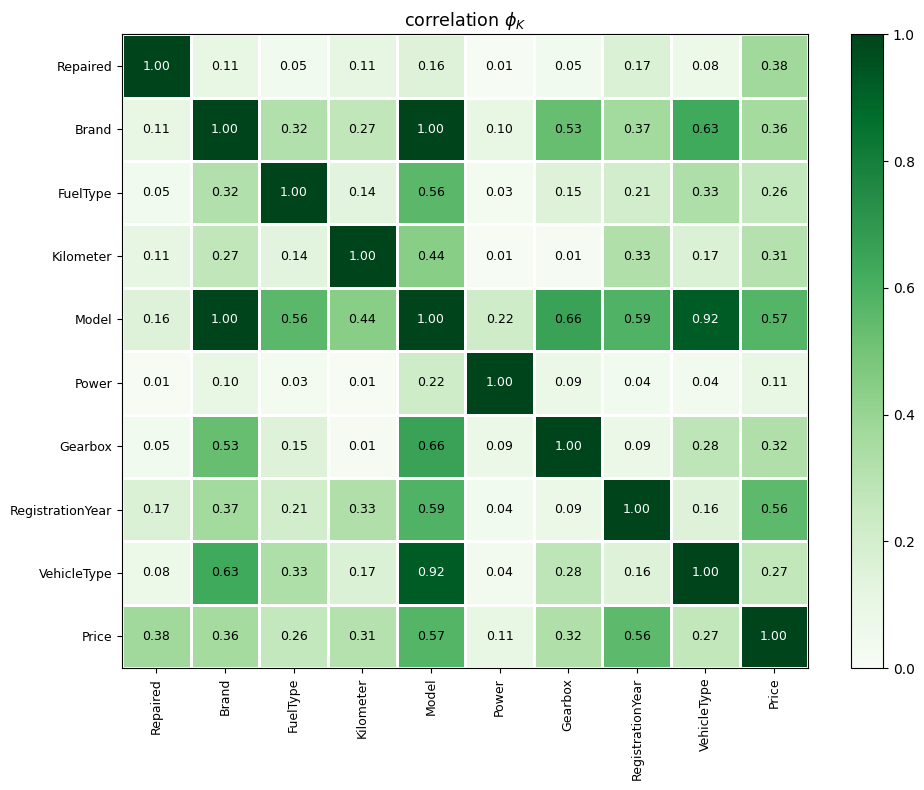

In [45]:
# построим plot_correlation_matrix:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9,
                        figsize=(10, 8))
plt.tight_layout()
plt.show()

## Разделение на выборки

In [46]:
X = df.drop(['Price'], axis = 1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
# посмотрим на размеры выборок:
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (233048, 9)
Размер тестовой выборки: (114786, 9)


In [48]:
# внесем в переменные списки все численные и категориальные признаки:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

In [49]:
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [50]:
numeric_features

['RegistrationYear', 'Power', 'Kilometer']

# Обучение моделей
## LinearRegression	

In [51]:
cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='unknown', add_indicator=True)),
    ('enc', OneHotEncoder(handle_unknown='error', drop='first', sparse_output=False))
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())  
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)

])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [52]:
score = ((cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error') * -1) ** 0.5).mean()

In [53]:
print('Среднее качество LinearRegression на кросс-валидации =', round(score, 2))

Среднее качество LinearRegression на кросс-валидации = 2791.43


## LGBMRegressor	

In [54]:
# for col in X_train.columns:
#     if X_train[col].dtype == object:
#         X_train[col] = X_train[col].astype('category')

In [54]:
# class CategoryType(BaseEstimator, TransformerMixin):
# 
#     def transform(self, X):
#         for col in X.columns:
#             if col in X[col].dtype == object:
#                 X.train[col] = X_train[col].astype('category')
#         return X
# 
#     def fit(self, X, y=None):
#         return self

In [83]:
cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='unknown', add_indicator=True)),
    ('enc', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
])

In [55]:
# X_train_new = preprocessor.fit_transform(X_train)

In [88]:
# X_train_new.dtypes

In [78]:
# for col in X_train_new.columns:
#     if X_train_new[col].dtype == object:
#         X_train_new[col] = X_train_new[col].astype('category')

In [69]:
# cat_features=list(X_train_new.columns[:-3])

In [68]:
# cat_features=['cat__VehicleType',
#               'cat__Gearbox',
#               'cat__Model',
#               'cat__FuelType',
#               'cat__Brand',
#               'cat__Repaired',
#               'cat__missingindicator_VehicleType',
#               'cat__missingindicator_Gearbox',
#               'cat__missingindicator_Model',
#               'cat__missingindicator_FuelType',
#               'cat__missingindicator_Repaired']

In [84]:
def optuna_optimize(trial):
    param = {
        'model__num_iterations': trial.suggest_int('model__num_iterations', 50, 900),
        'model__max_depth': trial.suggest_int('model__max_depth', -1, 20),
        'model__max_bin': trial.suggest_int('model__max_bin', 100, 255),
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 1),
        'model__num_leaves': trial.suggest_int('model__num_leaves', 32, 128),
        'model__min_data_in_leaf': trial.suggest_int('model__min_data_in_leaf', 5, 30),
        'model__lambda_l1': trial.suggest_float('model__lambda_l1', 0.0, 0.1),
        'model__min_child_weight': trial.suggest_float('model__min_child_weight', 0.0, 5.0)
    }
    
    estimator = LGBMRegressor(**param,
                              verbosity=-1, 
                              random_state=42,
                              categorical_feature=[0,1,2,3,4,5,6,7,8,9,10])

    pipe_lgbm = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    score = ((cross_val_score(pipe_lgbm, X_train, y_train, cv=5, scoring='neg_mean_squared_error') * -1) ** 0.5).mean()
    return score

In [85]:
study_lightgbm = optuna.create_study(study_name="LightGBM Optuna Optimization",
                                   direction='minimize')

[I 2023-12-09 13:07:59,420] A new study created in memory with name: LightGBM Optuna Optimization


In [86]:
study_lightgbm.optimize(optuna_optimize, n_trials=5)

[I 2023-12-09 13:08:16,116] Trial 0 finished with value: 1793.5903721801587 and parameters: {'model__num_iterations': 549, 'model__max_depth': 19, 'model__max_bin': 155, 'model__learning_rate': 0.9423368614164568, 'model__num_leaves': 75, 'model__min_data_in_leaf': 14, 'model__lambda_l1': 0.003877676227025795, 'model__min_child_weight': 4.067710932534493}. Best is trial 0 with value: 1793.5903721801587.
[I 2023-12-09 13:08:30,471] Trial 1 finished with value: 1793.5903721801587 and parameters: {'model__num_iterations': 588, 'model__max_depth': 13, 'model__max_bin': 110, 'model__learning_rate': 0.5939745964944093, 'model__num_leaves': 122, 'model__min_data_in_leaf': 8, 'model__lambda_l1': 0.068771273066387, 'model__min_child_weight': 0.9074432764447599}. Best is trial 0 with value: 1793.5903721801587.
[I 2023-12-09 13:08:45,145] Trial 2 finished with value: 1793.5903721801587 and parameters: {'model__num_iterations': 642, 'model__max_depth': 4, 'model__max_bin': 125, 'model__learning_ra

In [87]:
print("Наилучшие значения гиперпараметров LightGBM: {}".format(study_lightgbm.best_params))
print()
print("Среднее качество LightGBM на кросс-валидации = {:.2f}". format(study_lightgbm.best_value))

Наилучшие значения гиперпараметров LightGBM: {'model__num_iterations': 549, 'model__max_depth': 19, 'model__max_bin': 155, 'model__learning_rate': 0.9423368614164568, 'model__num_leaves': 75, 'model__min_data_in_leaf': 14, 'model__lambda_l1': 0.003877676227025795, 'model__min_child_weight': 4.067710932534493}

Среднее качество LightGBM на кросс-валидации = 1793.59


## CatBoostRegressor	